# Notebook for Protein Predict
Please first set the dir paths before running

In [1]:
import numpy as np

import scanpy as sc
import torch
import warnings
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from Model.dgat import GATEncoder, Decoder_Protein, Decoder_mRNA
from utils.Preprocessing import qc_control_cytassist, normalize, clean_protein_names, fill_genes, preprocess_ST
from Model.Train_and_Predict import train_and_evaluate_fold, protein_predict,get_activity

import random
import os

from utils.idk_utils import leiden_plot, find_edges,leiden_plot_scatter

warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

ST_data_dir = './DGAT_predition_ST_data' # Directory where the ST data is stored. Please set this to the directory where your ST data is stored.

pyg_save_dir = './pyg_data' # Building a graph might take 5 mins or more (depends on the scale of the dataset).This directory is used to save the graph data in PyG format, which can be reused for prediction without rebuilding the graph.
model_save_dir = './DGAT_pretrained_models'# Directory to save the trained DGAT model. If you have a pre-trained model , please set this to the directory where the model is saved. 
pred_result_path = './DGAT_results' # Not necessary to set this directory, but if you want to save the prediction results, please set this to the directory where you want to save the results and uncomment the last line of each section.

hidden_dim=1024
dropout_rate=0.3



seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/ihome/crc/install/pytorch/2.0.1/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load common genes and proteins for prediction


The current **common_gene_11535.txt** and **common_protein_31.txt** files are used for the prediction using pretrained model. The following steps will load them and ensure that the test dataset has the same genes as the training dataset. Lost genes will be filled with zeros. 


In [2]:
with open("./resources/common_gene_11535.txt", "r") as f: 
    common_gene = [line.strip() for line in f]

with open("./resources/common_protein_31.txt", "r") as f: 
    common_protein = [line.strip() for line in f]

## Prediction Pipeline

Prediction requires an existing DGAT model, which can be trained using the [Train_all.ipynb](Train_all.ipynb) notebook. Please set the `model_save_dir` to the directory where the trained model is saved. Or you may use the pretrained model provided [here](https://drive.google.com/drive/folders/1M9gIOFjK4wBk7DEj9MrwAlV8OHEgS2BA?usp=sharing), please save the pretrained model at `model_save_dir`.


### Lymph Node

In [3]:
import tarfile
if not hasattr(tarfile, 'data_filter'):
    tarfile.data_filter = None 

import scanpy as sc
adata_LN = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_LN.var_names_make_unique()
celltypes = pd.read_csv("./resources/W_cell_density.csv", index_col=0)
gc_annotation = pd.read_csv("./resources/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)
obs_names = np.intersect1d(celltypes.index, adata_LN.obs_names)
adata_LN = adata_LN[obs_names]
celltypes = celltypes.loc[obs_names]
gc_annotation = gc_annotation.loc[obs_names]
adata_LN.obsm['celltype'] = celltypes
adata_LN.obsm['celltype'].columns = [x.replace('mean_spot_factors','') for x in adata_LN.obsm['celltype'].columns]
adata_LN.obsm['celltype_raw'] = adata_LN.obsm['celltype'].copy()
adata_LN.obsm['celltype'] = adata_LN.obsm['celltype'].divide(adata_LN.obsm['celltype'].sum(axis=1), axis=0)
adata_LN.obs['germinal_center'] = gc_annotation
adata_LN.obs['germinal_center'] = adata_LN.obs['germinal_center'].map({0: "Other", 1: "GC"})

preprocess_ST(adata_LN) # Performs quality control and normalization on a Spatial Transcriptomics dataset.  
adata_LN = fill_genes(adata_LN, common_gene) # Ensures that the test dataset contains the same genes as the training dataset.  Fills missing genes in the test data with zeros.  


Sample lost 0 genes, 11535 in total


In [4]:
points, edges = find_edges(adata_LN)


In [5]:
pdata_LN = protein_predict(adata_LN,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'V1_Human_Lymph_Node' from '/ix/hosmanbeyoglu/haw309/pyg_data/V1_Human_Lymph_Node_11535_spatial=6_testing.pth'
Dataset ready


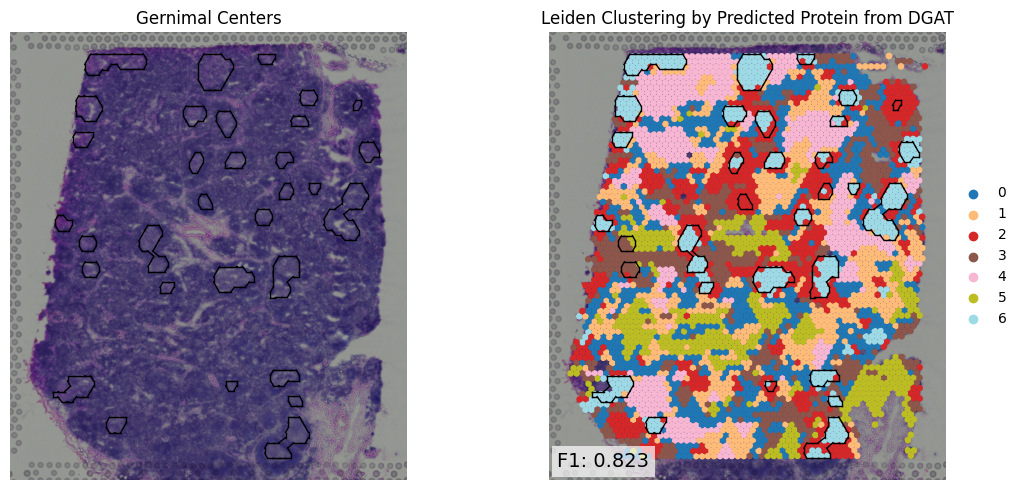

In [6]:
pdata_LN = leiden_plot(pdata_LN,n_neighbors = 10, points = points, edges = edges, plot_type = 'F1', resolution = 0.43,size = 1.7,title=f'Leiden Clustering by Predicted Protein from DGAT', palette = 'tab20',save_fig = False)


In [7]:
#pdata_LN.write(f'{pred_result_path}/LN.h5ad')

### TNBC

In [8]:
adata_Breast = sc.read_h5ad(f"{ST_data_dir}/CID44971.h5ad")


In [9]:
preprocess_ST(adata_Breast)
adata_Breast = fill_genes(adata_Breast, common_gene)

Sample lost 161 genes, 11535 in total


In [10]:
pdata_Breast = protein_predict(adata_Breast,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'CID44971' from '/ix/hosmanbeyoglu/haw309/pyg_data/CID44971_11535_spatial=6_testing.pth'
Dataset ready


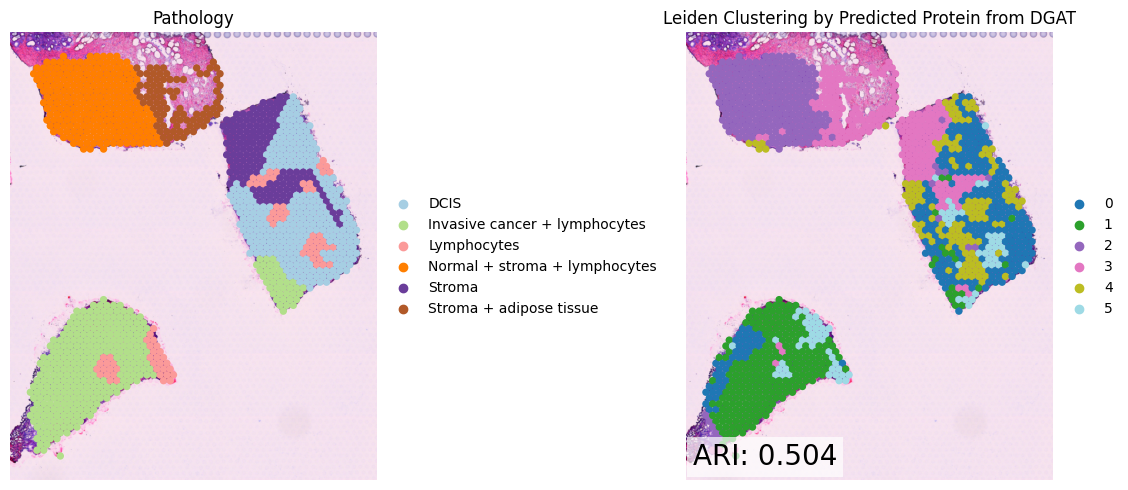

In [11]:
pdata_Breast = leiden_plot(pdata_Breast,n_neighbors = 10, plot_type = 'ARI', resolution = 0.45, true_label_key = 'pathology', size = 1.7,title=f'Leiden Clustering by Predicted Protein from DGAT', palette = 'tab20',save_fig = False)


In [12]:
#pdata_Breast.write(f'{pred_result_path}/CID44971_50.h5ad')

### Melanoma

In [13]:
adata_Melanoma = sc.read_h5ad(f"{ST_data_dir}/Melanoma.h5ad")

In [14]:

preprocess_ST(adata_Melanoma)
adata_Melanoma = fill_genes(adata_Melanoma, common_gene)

Sample lost 756 genes, 11535 in total


In [15]:
pdata_Melanoma = protein_predict(adata_Melanoma,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'Melanoma' from '/ix/hosmanbeyoglu/haw309/pyg_data/Melanoma_11535_spatial=6_testing.pth'
Dataset ready


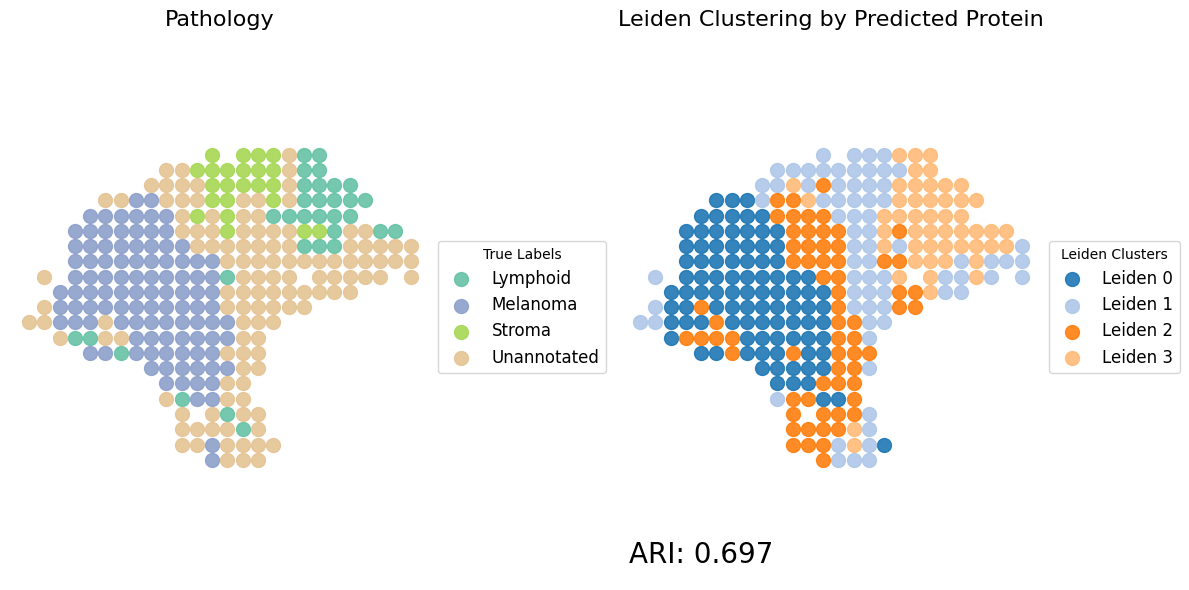

In [16]:
pdata_Melanoma = leiden_plot_scatter(pdata_Melanoma, n_neighbors=10, resolution=0.42, true_label_key = 'annotation', None_anno_cluster = 'Unannotated')

In [17]:
#pdata_Melanoma.write(f'{pred_result_path}/Melanoma.h5ad')

### Prostate

In [ ]:
adata_Prostate = sc.read_h5ad(f"{ST_data_dir}/Prostate.h5ad")

In [19]:

preprocess_ST(adata_Prostate)
adata_Prostate = fill_genes(adata_Prostate, common_gene)

Sample lost 393 genes, 11535 in total


In [20]:
pdata_Prostate = protein_predict(adata_Prostate,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'Prostate' from '/ix/hosmanbeyoglu/haw309/pyg_data/Prostate_11535_spatial=6_testing.pth'
Dataset ready


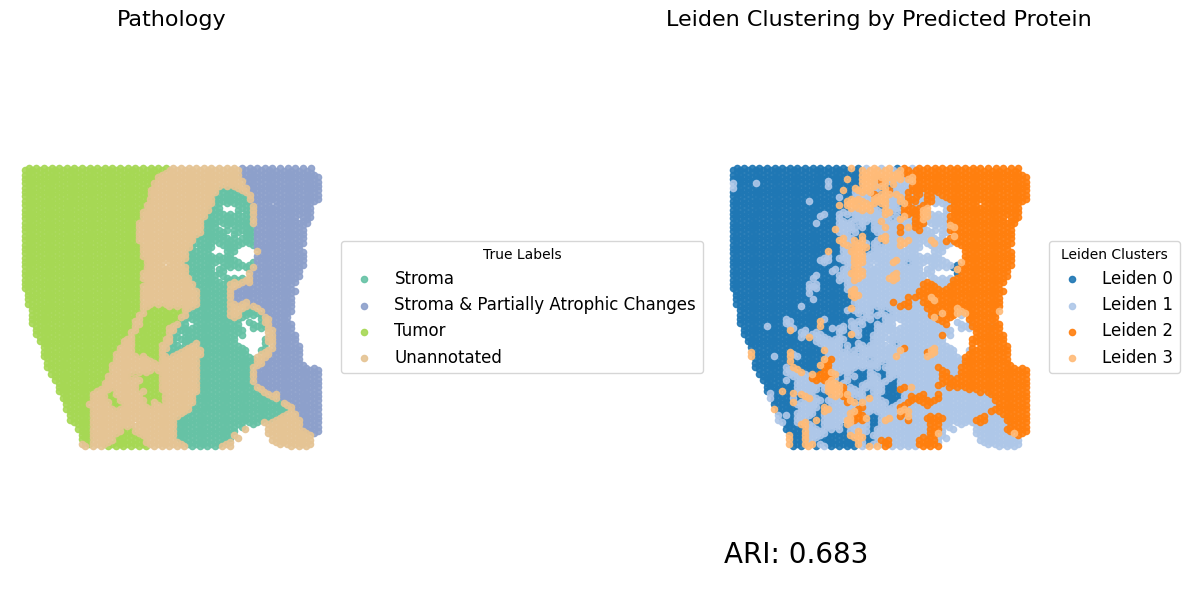

In [21]:
pdata_Prostate = leiden_plot_scatter(pdata_Prostate, n_neighbors=10, size = 20, resolution=0.251, true_label_key = 'annotation', None_anno_cluster = 'Unannotated')

In [22]:
#pdata_Prostate.write(f'{pred_result_path}/Prostate.h5ad')

### iImpacr Breast 10X

In [23]:
adata_iBreast = sc.read_h5ad(f"{ST_data_dir}/Breast.h5ad")

In [24]:
preprocess_ST(adata_iBreast)
adata_iBreast = fill_genes(adata_iBreast, common_gene)

Sample lost 393 genes, 11535 in total


In [25]:
pdata_iBreast = protein_predict(adata_iBreast,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'Breast_10X' from '/ix/hosmanbeyoglu/haw309/pyg_data/Breast_10X_11535_spatial=6_testing.pth'
Dataset ready


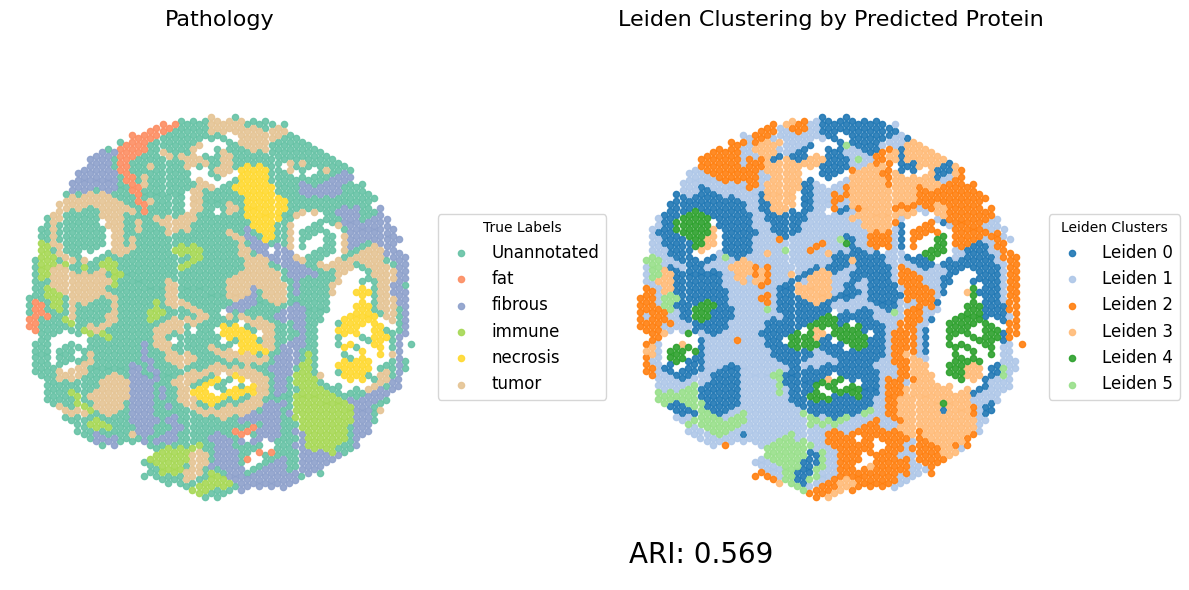

In [26]:
pdata_iBreast = leiden_plot_scatter(pdata_iBreast, n_neighbors=10, size = 20, resolution=0.318, true_label_key = 'annotation', None_anno_cluster = 'Unannotated')

In [27]:
#pdata_iBreast.write(f'{pred_result_path}/iBreast.h5ad')

### Ovarian

In [28]:
adata_Ovarian = sc.read_h5ad(f"{ST_data_dir}/Ovarian.h5ad")



In [29]:

preprocess_ST(adata_Ovarian)
adata_Ovarian = fill_genes(adata_Ovarian, common_gene)

Sample lost 393 genes, 11535 in total


In [30]:
pdata_Ovarian = protein_predict(adata_Ovarian,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'Ovarian' from '/ix/hosmanbeyoglu/haw309/pyg_data/Ovarian_11535_spatial=6_testing.pth'
Dataset ready


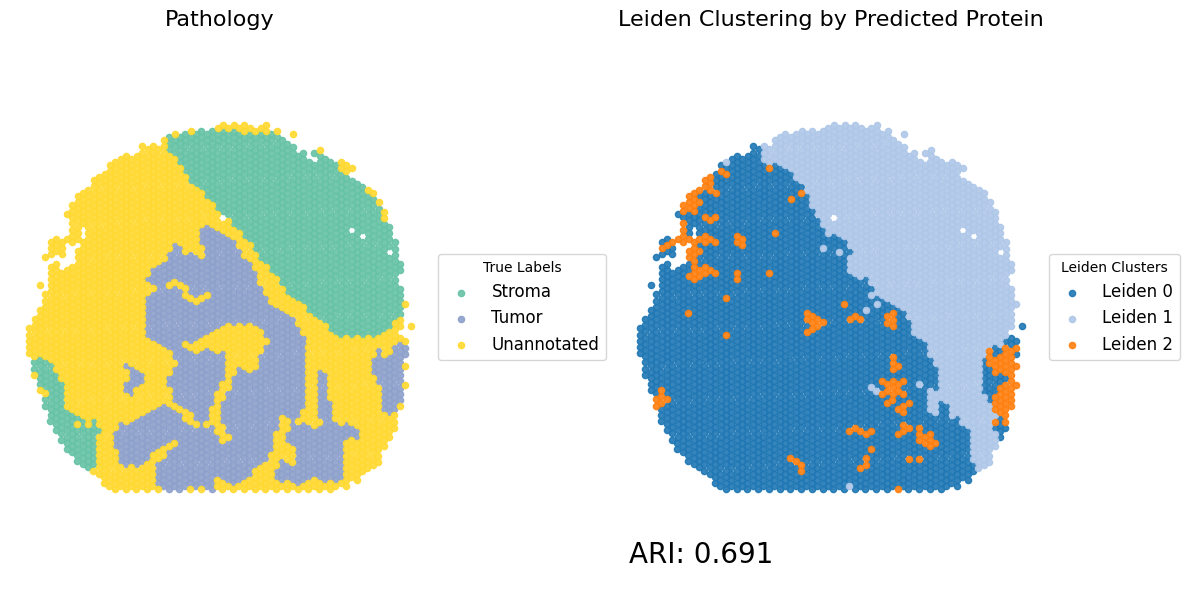

In [31]:
pdata_Ovarian = leiden_plot_scatter(pdata_Ovarian, n_neighbors=10, size = 20, resolution=0.103, true_label_key = 'annotation', None_anno_cluster = 'Unannotated')

In [32]:
#pdata_Ovarian.write(f'{pred_result_path}/iOvarian.h5ad')